In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#from google.colab import drive
#drive.mount('/content/drive')
# Custom funcion definitions

def process_dates(df):
    # Process Dates
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year 
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df.drop(['Date'], axis=1, inplace=True)
    return df


def process_YES_NO(df):
    # Process rain
    df.replace({'No': 0, 'Yes': 1}, inplace=True)
    # df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
    # df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)
    return df


def preprocess_data(df):
    # Converting and splitting date to Year, Month and Day
    df = process_dates(df.copy())
    # Converting "Yes" and "No" to "0" and "1" respectively
    df = process_YES_NO(df)

    # Split Numeric and Catogrical Features
    numeric_features = list(df.select_dtypes(include=['float64']).columns)
    category_features = list(df.select_dtypes(include=['object']).columns)

    # Filling NAs
    # RainTomorrow: remove NA rows
    # RainToday: remove NA rows
    df.dropna(subset=['RainTomorrow','RainToday'],inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Columns where NAs will be replaced with middle value of previous and next day data.
    mid_cols = ['Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Cloud9am','Cloud3pm','Evaporation']

    for feature in mid_cols:
        # Finding rows that are NaNs but are sandwiched between two valid values
        i = df[(df[feature].isnull()) & (df[feature].shift(-1).notnull()) & (df[feature].shift().notnull())]
        j = i.index
        df.loc[j,feature] = (df.loc[j-1,feature] + df.loc[j+1,feature])/2

    # Fill remaining values with zeros
    # Columns where NAs will be replaced with zeros under the assumption that no activity is monitored.
    zero_cols = ['Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Cloud9am','Cloud3pm','Evaporation']
    for feature in zero_cols:
        df[feature].fillna(0, inplace=True)

    # In all other numeric columns NAs will be replaced with median

    # Find remaning numeric features
    numeric_features = list(set(numeric_features) - set(zero_cols) - set(['RainToday', 'RainTomorrow']))

    for feature in numeric_features:
        feature_median = df[feature].median()
        df[feature].fillna(feature_median, inplace=True)

    # NAs in categorical columns will be filled with mode
    for feature in category_features:
        feature_mod = df[feature].mode()[0]
        df[feature].fillna(feature_mod, inplace=True)

    #df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
    #df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
    #df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)
    #df.drop(category_features, axis=1, inplace=True)

    # Drop Features with high correlation with each other and those who have low cross correlation with output
    drop_featrures = ['Temp3pm','Pressure3pm','Year','Month','Day']
    df = df.drop(drop_featrures,axis=1);

    # One hot encoding for all categorical features
    df = pd.get_dummies(df, columns=category_features)

    y = df['RainTomorrow'].copy()

    return df, y

def cyclic_encode(df, col):
    max_val = df[col].max()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop([col], axis=1, inplace=True)
    return df

def convert_2numpy(X):
    X = X.to_numpy()
    return X

def normalize(X, *args):
    if args:
        meanX = args[0]
        stdX = args[1]
    else:
        meanX = X.mean(axis=0)
        stdX = X.std(axis=0)
        stdX[abs(stdX) <= 1e-8] = 1e-8  

    Xnorm = (X - meanX)/stdX
    return Xnorm, meanX, stdX

def append_ones(X):
    X = np.c_[np.ones(X.shape[0]),X]
    return X

def splitTestTrain(X, y, test_percentage, seedVal=42):
    portion = int(test_percentage/100*len(y))
    
    np.random.seed(seedVal)
    np.random.RandomState(seedVal)

    order = np.random.permutation(len(X))
    portion = portion # percent
    X_test = X[order[:portion]]
    y_test = y[order[:portion]]
    X_train = X[order[portion:]]
    y_train = y[order[portion:]] 
    return X_test, y_test, X_train, y_train

def NormalEquation(X, y):
    X_trans = X.transpose()
    W = np.linalg.inv(X_trans.dot(X))
    W = W.dot(X_trans)
    W = W.dot(y)
    return W

# Mean Squared Loss
def loss_MSE(X, y, W, n):
    y_pred = X.dot(W)
    error = y_pred-y
    MSE = 1/n * np.sum(np.power(error,2))
    return MSE

# Cross Entropy Loss
def loss_CE(h, y):
    n = y.shape[0]
    h = h.reshape((n,1))
    y = y.reshape((n,1))
    epsilon = 1e-5
    loss = -(1.0/n) * (np.dot((np.log(h+epsilon)).T, y) + np.dot((np.log(1-h+epsilon)).T, (1-y)))
    return np.squeeze(loss)
    

def CE_gradient(X, y, W, n):
    h = predict(X, W)
    gradient = (1.0/n) * np.dot((h - y).T , X)
    return gradient

    
def gradient_descent(X, y, alpha, lmbda, max_iterations, tol):
    n = len(y)
    # np.random.seed()
    # W = np.random.randn(X.shape[1])
    W = np.zeros(X.shape[1])
    lossarray = []
    accarray = []
    loss = 0
    acc = 0
    
    for iteration in range(max_iterations):
        
        #alphan = alpha*(1.0e-04*iteration + 1.0)
        # alphan = alpha*(-5.0e-03*iteration + 1.0)
        alphan  = alpha
        # L1 Regularization
        Wn = W - alphan * (CE_gradient(X, y, W, n) + 1.0/n*lmbda*np.abs(W))
        
        # Stopping Condition
        if np.sum(abs(Wn - W)) < tol:
            print("Tolerance reached.")
            break

        W = Wn
        h = predict(X, W)
        loss = loss_CE(h, y) + 1.0/n*lmbda*np.sum(W)
        lossarray.append(loss) # Loss array to collect losses in each iteration
        ypred = predict(X, W)
        ypred = ypred > 0.5
        acc = modelAccuracy(ypred, y, 0)
        accarray.append(acc)

        # Print loss every 50 iterations
        if (iteration+1) % 50 == 0:
            print("Iteration: %d - Loss: %.8f - Acc: %0.4f" %(iteration+1, loss, acc))

    return W, lossarray, accarray


def sigmoid(x):
    return 1/(1 + np.exp(-x))


def predict(X, W):
    return sigmoid(X.dot(W))

def modelAccuracy(ypred, y_test, pOut=1):
    # y_test = y_test.squeeze
    # Model Accuracy
    TP = np.sum(np.logical_and(ypred == 1, y_test == 1))
    TN = np.sum(np.logical_and(ypred == 0, y_test == 0))
    FP = np.sum(np.logical_and(ypred == 1, y_test == 0))
    FN = np.sum(np.logical_and(ypred == 0, y_test == 1))
    
    if pOut == 1:
        print("True Posoitive: ", TP)
        print("True Negative:  ", TN)
        print("False Posoitive:", FP)
        print("False Negative: ", FN)
        
    #Precision = TP/(TP + FP) 
    #NPV = TN/(TN + FN)
    #Sensitivity = TP / (TP + FN)
    #Specifity = TN / (TN + FP)
    Accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    # Confusion Matrix
    #confusion_matrix = np.array([[TP, FP, Precision],[FN, TN, NPV],[Sensitivity, Specifity, Accuracy]])
    # np.set_printoptions(precision=2,suppress=True)
    #print(confusion_matrix)
    if pOut == 1:
        print("Model Accuracy: ", Accuracy*100, " %")
    
    return Accuracy*100

def Kfold(X_train, y_train, k):
    X_train_folds = np.array_split(X_train, k)
    y_train_folds = np.array_split(y_train, k)
    return X_train_folds, y_train_folds


def LogisticRegressionTrain(X_train, y_train, alpha, lmbda, max_iterations, tol=1e-8):
    # Using Gradinet Descent
    W, loss, acc = gradient_descent(X_train, y_train, alpha, lmbda, max_iterations, tol)
    return W, loss, acc


In [2]:
# Loading Data
# df = pd.read_csv("/content/drive/MyDrive/weatherAUS.csv")
df = pd.read_csv("weatherAUS.csv")

In [3]:
# correlation
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

# plt.figure(figsize = (12, 16))
# h = sb.heatmap(corr, cmap='coolwarm', annot=True, cbar=False)
# h.set_yticklabels(h.get_yticklabels(), rotation = 0)
# h.xaxis.tick_top()
# h.set_xticklabels(h.get_xticklabels(), rotation = 90)

#h.figure.savefig(YOURPATH, bbox_inches='tight')

In [4]:
# Corrleation with Output
# df2 = process_YES_NO(df)
# y = df2['RainTomorrow'].copy()
# ycorr = df2.corrwith(y)
# print(ycorr)


In [5]:
# Data Pre-Processing
dfp, y = preprocess_data(df)

# Encoding Cyclic Features
#X = cyclic_encode(X,'Day')
#X = cyclic_encode(X,'Month')

# Convert Pandas dateframe to numpy
X = dfp.drop(['RainTomorrow'], axis=1)
X = convert_2numpy(X)
y = convert_2numpy(y)

In [6]:
# Make Feature Matrix (Append ones)
X = append_ones(X)

In [7]:
# Splitting data in test, training sets
X_test, y_test, X_train, y_train = splitTestTrain(X, y, 30)

In [8]:
# Normalization 
X_train_norm, meanX, stdX = normalize(X_train)
# Noramalizing test data with the meana nd std of training data
X_test_norm, *_ = normalize(X_test, meanX, stdX)

In [9]:
# Training with cross validation
alpha = 1
lmbda = np.array([1])
k = 5 # numberOfFolds
X_ , y_ =  Kfold(X_train_norm, y_train, k)
model_accuracies = np.ndarray((len(lmbda),k))
losses = np.ndarray((len(lmbda),k))
models = np.ndarray((len(lmbda),k,X_train_norm.shape[1]))
for i in range(len(lmbda)):
    print('Lambda  = ',lmbda[i])
    for j in range(k):
        print('Fold: %d' %(j+1))
        X_train_k, X_validate_k = np.concatenate(X_[:j] + X_[j+1:]), X_[j]
        y_train_k, y_validate_k = np.concatenate(y_[:j] + y_[j+1:]), y_[j]
        model_k, loss_k, acc_k = LogisticRegressionTrain(X_train_k, y_train_k, alpha, lmbda[i], 100)
        # models[i][j] = model_k
        losses[i][j] = loss_k[-1]
        ypred_k = predict(X_validate_k, model_k)
        ypred_k = ypred_k > 0.5
        model_accuracies[i][j] = modelAccuracy(ypred_k, y_validate_k, 0)
    print('Average Accuracy = ',np.mean(model_accuracies[i][:]))

Lambda  =  1
Fold: 1
Iteration: 50 - Loss: 0.56457792 - Acc: 73.0124
Iteration: 100 - Loss: 0.56377570 - Acc: 73.3650
Fold: 2
Iteration: 50 - Loss: 0.56331283 - Acc: 73.2373
Iteration: 100 - Loss: 0.56236769 - Acc: 73.6216
Fold: 3
Iteration: 50 - Loss: 0.56299204 - Acc: 73.0914
Iteration: 100 - Loss: 0.56207258 - Acc: 73.4123
Fold: 4
Iteration: 50 - Loss: 0.56310116 - Acc: 73.1739
Iteration: 100 - Loss: 0.56222338 - Acc: 73.5315
Fold: 5
Iteration: 50 - Loss: 0.56411565 - Acc: 73.0965
Iteration: 100 - Loss: 0.56326044 - Acc: 73.4580
Average Accuracy =  73.40869094694335


In [10]:
np.mean(model_accuracies,axis=1)
print("\tlmbda\t 5-fold cross validation Accuracy")
print(np.array([lmbda, np.mean(model_accuracies,axis=1)]).T)

	lmbda	 5-fold cross validation Accuracy
[[ 1.         73.40869095]]


In [65]:
# Traning with Final parameters
lmbda = 1.0
alpha = 1.0
model, loss, acc = LogisticRegressionTrain(X_train_norm, y_train, alpha, lmbda, 10000)
ypred = predict(X_train_norm, model)
ypred = ypred > 0.5
print('Training Accuracy = ', modelAccuracy(ypred, y_train))

Iteration: 50 - Loss: 0.56375440 - Acc: 73.1104
Iteration: 100 - Loss: 0.56287832 - Acc: 73.4736
Iteration: 150 - Loss: 0.56269804 - Acc: 73.6319
Iteration: 200 - Loss: 0.56263917 - Acc: 73.6806
Iteration: 250 - Loss: 0.56261577 - Acc: 73.6857
Iteration: 300 - Loss: 0.56260509 - Acc: 73.6989
Iteration: 350 - Loss: 0.56259972 - Acc: 73.6999
Iteration: 400 - Loss: 0.56259686 - Acc: 73.7070
Iteration: 450 - Loss: 0.56259528 - Acc: 73.7040
Iteration: 500 - Loss: 0.56259439 - Acc: 73.6979
Iteration: 550 - Loss: 0.56259388 - Acc: 73.7050
Iteration: 600 - Loss: 0.56259358 - Acc: 73.6979
Iteration: 650 - Loss: 0.56259340 - Acc: 73.6969
Iteration: 700 - Loss: 0.56259329 - Acc: 73.6918
Iteration: 750 - Loss: 0.56259321 - Acc: 73.6918
Iteration: 800 - Loss: 0.56259316 - Acc: 73.6918
Iteration: 850 - Loss: 0.56259313 - Acc: 73.6877
Iteration: 900 - Loss: 0.56259310 - Acc: 73.6877
Iteration: 950 - Loss: 0.56259308 - Acc: 73.6867
Iteration: 1000 - Loss: 0.56259306 - Acc: 73.6867
Iteration: 1050 - Lo

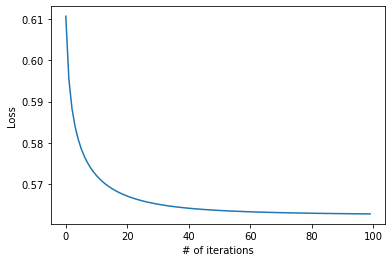

In [12]:
# Plotting Training Loss
# plt.plot(loss, label='alpha = 1e-4(1e-4 * ietartion + 1.0)')
plt.plot(loss)
plt.xlabel('# of iterations')
plt.ylabel('Loss')
# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

In [13]:
# Model Testing
print(model)
ypred_LR = predict(X_test_norm, model)
ypred_LR = ypred_LR > 0.5
LogisticRegressionTestAcuracy = modelAccuracy(ypred_LR, y_test);

[ 0.00000000e+00 -8.65798614e-02  7.61201775e-02  4.50092150e-01
  3.76369977e-02 -2.44558017e-01  5.23761700e-01  1.28761227e-02
 -1.88122597e-01 -6.06766408e-02  9.55432114e-01 -2.76449500e-01
  7.98287344e-04  1.71955822e-01  1.49671314e-02  7.85146139e-02
  7.30344634e-02  1.03595689e-01  2.26779426e-03  7.87100108e-02
 -5.53649924e-03 -8.04003252e-02 -3.14533892e-02  4.19124230e-02
  1.65876275e-03 -3.62126086e-03  2.59212040e-02 -1.63715278e-02
  2.99227654e-02 -6.23384709e-03 -4.32429626e-02 -6.21065813e-02
 -6.21980355e-02 -8.54063967e-02 -8.30574575e-03 -2.80345168e-02
  6.04831199e-02  3.82205111e-02  1.38111851e-02 -1.12992210e-01
  3.43884456e-02 -9.34101289e-03 -7.03624170e-02 -5.27187180e-02
  3.31299534e-02  5.93100983e-02  5.75380517e-03  6.32613250e-02
  5.50629557e-02 -7.63522571e-03 -9.29718914e-03 -4.43815362e-02
  1.36804456e-02  6.07650720e-02  1.37454603e-02 -5.40122053e-02
 -6.82358599e-03  3.22247884e-02  4.25735700e-02 -2.08310788e-02
 -9.84516698e-03 -4.42509

In [14]:
# Naive Bayes Classifier
# Split the dataset by true and false classes
def separate_by_class(X,y):
    I_true  = np.where(y == 1)
    X_true  = np.squeeze(X[I_true,:])
    I_false = np.where(y == 0)
    X_false = np.squeeze(X[I_false,:])
    return X_true, X_false

In [15]:
# Calculate Log Prior Probabilities
def log_prior_NB(y):
    P_y_true = np.log(np.sum(y)/len(y))
    P_y_false = np.log((len(y) - np.sum(y))/len(y))
    return np.array([P_y_true, P_y_false])

In [16]:
# Distribution Parameters
def parameters_NB(X,y):
    X_true, X_false = separate_by_class(X,y)
    meanX = np.vstack((X_true.mean(axis=0), X_false.mean(axis=0)))
    stdX = np.vstack((X_true.std(axis=0), X_false.std(axis=0)))
    stdX[stdX==0] = 1e-8;
    return  meanX, stdX

In [17]:
# Calculate Log Likelihhod Probabilities
def calculate_log_probability(X, meanX, stdX):
    exponent = np.exp(-((X-meanX)**2 / (2 * stdX**2 )))
    return np.log(exponent / (np.sqrt(2 * np.pi)* stdX))

In [18]:
# Predict Labels
def predict_NB(X):

    meanX, stdX = parameters_NB(X_train,y_train)
    log_prior_y = log_prior_NB(y_train);
    P_y_true_given_X = np.squeeze(np.ndarray((1,len(X))))
    P_y_false_given_X = np.squeeze(np.ndarray((1,len(X))))
    y_NB = np.squeeze(np.ndarray((1,len(X))))
    for i in range(len(X) - 1):
        P_y_true_given_X[i] = np.sum(calculate_log_probability(X[i,:], meanX[0,:], stdX[0,:])) + log_prior_y[0]
        P_y_false_given_X[i] = np.sum(calculate_log_probability(X[i,:], meanX[1,:], stdX[1,:])) + log_prior_y[1]
        if (P_y_true_given_X[i] > P_y_false_given_X[i]):
            y_NB[i] = 1
        else:
            y_NB[i] = 0          
    return y_NB

In [19]:
# Testing
y_NB = predict_NB(X_test)
NaiveBayesTestAccuracy = modelAccuracy(y_NB, y_test)


/tmp/ipykernel_23223/1828221285.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(exponent / (np.sqrt(2 * np.pi)* stdX))


True Posoitive:  6666
True Negative:   20109
False Posoitive: 12709
False Negative:  2751
Model Accuracy:  63.39528826802415  %


In [57]:
# Multilayer Perceptron
 
def forward_pass(X, w_1, w_2, w_o):
    # hidden layer 1
    z_1 = X.dot(w_1)    # input from inpot layer
    a_1 = sigmoid(z_1)  # output to hidden layer 2
     
    # hidden layer 2
    z_2 = a_1.dot(w_2)  # input from hidden layer 1
    a_2 = sigmoid(z_2)  # output to output layer

    # Output layer
    z_o = a_2.dot(w_o)  # input from hidden layer 2
    a_o = sigmoid(z_o)  # output
    return(a_o)
  
# initializing the weights randomly
def initialize_wt(x, y):
    l =[]
    for i in range(x * y):
        l.append(np.random.randn())
    return(np.array(l).reshape(x, y))

# Back propagation of error
def back_pass(X, y, w_1, w_2, w_o, alpha):
    y = y.reshape((len(y),1))
    # hidden layer 1
    z_1 = X.dot(w_1)    # input from inpot layer
    a_1 = sigmoid(z_1)  # output to hidden layer 2
     
    # hidden layer 2
    z_2 = a_1.dot(w_2)  # input from hidden layer 1
    a_2 = sigmoid(z_2)  # output to output layer

    # Output layer
    z_o = a_2.dot(w_o)  # input from hidden layer 2
    a_o = sigmoid(z_o)  # output

    # deltas
    d_o = a_o - y       # output layer
    # d_2 = (a_2*(1-a_2)).dot(w_o) * d_o
    # d_1 = (a_1*(1-a_1)).dot(w_2) * d_2
    d_2 = (a_2*(1-a_2) * np.matmul(d_o,w_o.T))
    d_1 = (a_1*(1-a_1) * np.matmul(d_2,w_2.T))


    # d_2 = (w_o.dot((d_o.T))).T * (a_2 * 1-a_2)
 
    # gradients
    w_o_adj = np.matmul(a_2.T, d_o)
    w_2_adj = np.matmul(a_1.T, d_2)
    w_1_adj = np.matmul(X.T, d_1)
    
     
    # Updating parameters
    w_1 = w_1-(alpha*(w_1_adj))
    w_2 = w_2-(alpha*(w_2_adj))
    w_o = w_o-(alpha*(w_o_adj))
     
    return(w_1, w_2, w_o)

def trainMLP(X, y, w_1, w_2, w_o, alpha = 0.01, epoch = 10):
    accArray = []
    lossArray = []
    for j in range(epoch):
        out = forward_pass(X, w_1, w_2, w_o)
        loss = (loss_CE(out, y))
        w_1, w_2, w_o = back_pass(X, y, w_1, w_2, w_o, alpha)
        ypred = predictMLP(X, w_1, w_2, w_o)
        ypred = ypred > 0.5
        acc = modelAccuracy(ypred,y,0)
        accArray.append(acc)
        lossArray.append(loss)
        # Print loss every 50 iterations
        if (j+1) % 50 == 0:
            print("epochs:", j + 1, "========> Loss:", loss, "========> Accuracy:", acc)  
    return(accArray, lossArray, w_1, w_2, w_o)

def predictMLP(X, w_1, w_2, w_o):
    Out = forward_pass(X, w_1, w_2, w_o)
    return Out.squeeze()


In [58]:
# Initialize Weights
w_1 = initialize_wt(X.shape[1], 5) # Input  Layer   to Hidden Layer 1 (D, 5)
w_2 = initialize_wt(5, 5)          # Hidden Layer 1 to Hidden Layer 2 (5, 5)
w_o = initialize_wt(5, 1)          # Hidden Layer 2 to Output Layer   (5, 5)

# print(w_1, "\n\n", w_2, "\n\n", w_o)

epochs: 50 ========> Loss: 0.5372414383423855 ========> Accuracy: 77.8957088208136
epochs: 100 ========> Loss: 0.5178818932125193 ========> Accuracy: 77.8957088208136
epochs: 150 ========> Loss: 0.5088352934271309 ========> Accuracy: 77.8957088208136
epochs: 200 ========> Loss: 0.5016296666721893 ========> Accuracy: 77.8957088208136
epochs: 250 ========> Loss: 0.49401748919566624 ========> Accuracy: 77.8957088208136
epochs: 300 ========> Loss: 0.4857800561629159 ========> Accuracy: 77.8957088208136
epochs: 350 ========> Loss: 0.47725450748236486 ========> Accuracy: 78.22853142027985
epochs: 400 ========> Loss: 0.4688403865322404 ========> Accuracy: 78.59179511116072
epochs: 450 ========> Loss: 0.4608709610880287 ========> Accuracy: 78.8525737942791
epochs: 500 ========> Loss: 0.45353308167463774 ========> Accuracy: 79.3041166502623
epochs: 550 ========> Loss: 0.4469174030056997 ========> Accuracy: 79.56996884861645
epochs: 600 ========> Loss: 0.44102061223800404 ========> Accuracy: 79.

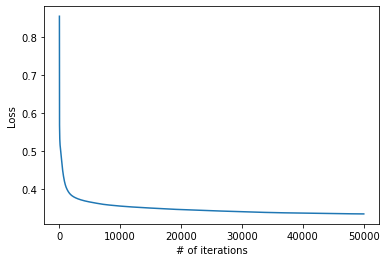

In [59]:
# Traning
acc, loss, w_1, w_2, w_o = trainMLP(X_train_norm, y_train, w_1, w_2, w_o, 0.0001, 20000)
# Plotting Training Loss
# plt.plot(loss, label='alpha = 1e-4(1e-4 * ietartion + 1.0)')
plt.plot(loss)
plt.xlabel('# of iterations')
plt.ylabel('Loss')
# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

In [63]:
# Training Accuracy
ypred_MLP = predictMLP(X_train_norm, w_1, w_2, w_o)
ypred_MLP = ypred_MLP > 0.5
modelAccuracy(ypred_MLP,y_train)

True Posoitive:  11706
True Negative:   72700
False Posoitive: 4067
False Negative:  10078
Model Accuracy:  85.64702539801728  %


85.64702539801728

In [62]:
# Testing Accuracy
ypred_MLP = predictMLP(X_test_norm, w_1, w_2, w_o)
ypred_MLP = ypred_MLP > 0.5
accuracyMLP = modelAccuracy(ypred_MLP,y_test)

True Posoitive:  4903
True Negative:   30973
False Posoitive: 1846
False Negative:  4514
Model Accuracy:  84.94175584809167  %


In [64]:
# Saving Model
import joblib
modelsFilename = 'FinalModels.mod'
modelLR = model
modelMLP = [w_1, w_2, w_o]
models = [modelLR, modelMLP]
joblib.dump(models, modelsFilename)

['FinalModels.mod']

In [2]:
# Loading Models
import joblib
modelsLoaded = joblib.load('FinalModels.mod')